#### CSC 180 Intelligent Systems

#### Dr. Haiquan Chen, Dept of Computer Scicence

#### California State University, Sacramento

## Lab 14: Natural Lauguage Processing with Pretrained Word Embedding (transfer learning)

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus.  There are several different versions ready to download.

Glove Vectors: https://nlp.stanford.edu/projects/glove/

Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download): http://nlp.stanford.edu/data/glove.840B.300d.zip

Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download): http://nlp.stanford.edu/data/glove.twitter.27B.zip

***We will use this twitter pretrained model in this lab***

In [1]:
import numpy as np
from numpy import array
import pandas as pd
#import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation, Dropout
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model





In [10]:
df = pd.read_csv('twitter4000.csv')
df.head()

,twitts,sentiment
0,is bored and wants to watch a movie any sugge...,0
1,back in miami. waiting to unboard ship,0
2,"@misskpey awwww dnt dis brng bak memoriessss, ...",0
3,ughhh i am so tired blahhhhhhhhh,0
4,@mandagoforth me bad! It's funny though. Zacha...,0


### Preprocessing and Cleaning

In [12]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and "}

In [13]:
import re

text = ' '.join(df['twitts'])
text = text.split()
freq_comm = pd.Series(text).value_counts()
rare = freq_comm[freq_comm.values == 1]

def get_clean_text(x):
    if type(x) is str:
        x = x.lower()
        for key in contractions:
            value = contractions[key]
            x = x.replace(key, value)
        x = re.sub(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', '', x)
        x = re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', x)
        x = re.sub('RT', "", x)
        x = re.sub('[^A-Z a-z]+', '', x)
        x = ' '.join([t for t in x.split() if t not in rare])
        return x
    else:
        return x

df['twitts'] = df['twitts'].apply(lambda x: get_clean_text(x))

In [14]:
df['twitts']

,twitts
0,is bored and wants to watch a movie any sugges...
1,back in miami waiting to
2,misskpey awwww dnt bak memoriessss i i am sad lol
3,ughhh i am so tired
4,mandagoforth me bad it is funny though zachary...
...,...
3995,i just
3996,templating works it all has to be done
3997,mommy just brought me starbucks
3998,omarepps watching you on a house rerunlovin it


In [15]:
df['sentiment'].value_counts()

,count
sentiment,
0,2000
1,2000


In [16]:
y = df['sentiment']

In [17]:
text = df['twitts'].tolist()
text[:3]

['is bored and wants to watch a movie any suggestions',
 'back in miami waiting to',
 'misskpey awwww dnt bak memoriessss i i am sad lol']

In [18]:
token = Tokenizer()
token.fit_on_texts(text)

In [24]:
token.index_word

{1: 'i',
 2: 'to',
 3: 'the',
 4: 'a',
 5: 'is',
 6: 'my',
 7: 'you',
 8: 'it',
 9: 'and',
 10: 'in',
 11: 'not',
 12: 'for',
 13: 'am',
 14: 'of',
 15: 'that',
 16: 'me',
 17: 'on',
 18: 'have',
 19: 'so',
 20: 'at',
 21: 'but',
 22: 'just',
 23: 'was',
 24: 'do',
 25: 'with',
 26: 'be',
 27: 'day',
 28: 'this',
 29: 'up',
 30: 'all',
 31: 'get',
 32: 'now',
 33: 'go',
 34: 'good',
 35: 'out',
 36: 'your',
 37: 'are',
 38: 'will',
 39: 'no',
 40: 'like',
 41: 'today',
 42: 'love',
 43: 'too',
 44: 'got',
 45: 'work',
 46: 'lol',
 47: 'going',
 48: 'back',
 49: 'what',
 50: 'time',
 51: 'from',
 52: 'had',
 53: 'cannot',
 54: 'know',
 55: 'about',
 56: 'amp',
 57: 'can',
 58: 'im',
 59: 'really',
 60: 'one',
 61: 'well',
 62: 'we',
 63: 'did',
 64: 'some',
 65: 'still',
 66: 'oh',
 67: 'its',
 68: 'want',
 69: 'they',
 70: 'there',
 71: 'see',
 72: 'miss',
 73: 'think',
 74: 'when',
 75: 'an',
 76: 'home',
 77: 'how',
 78: 'as',
 79: 'new',
 80: 'morning',
 81: 'night',
 82: 'need',
 8

In [25]:
vocab_size  = len(token.word_index) + 1
vocab_size

6793

In [26]:
encoded_text = token.texts_to_sequences(text)

In [27]:
print(encoded_text[:3])


[[5, 279, 9, 315, 2, 182, 4, 217, 202, 2298], [48, 10, 1299, 183, 2], [2299, 1087, 655, 1300, 2300, 1, 1, 13, 114, 46]]


In [28]:
max_length = 120
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [29]:
print(X)

[[   5  279    9 ...    0    0    0]
 [  48   10 1299 ...    0    0    0]
 [2299 1087  655 ...    0    0    0]
 ...
 [ 936   22  925 ...    0    0    0]
 [6791  125    7 ...    0    0    0]
 [  88   12  209 ...    0    0    0]]


In [30]:
X.shape

(4000, 120)

### `GloVe` Vectors

In [ ]:
# you -0.11076 0.30786 -0.5198 0.035138 0.10368 -0.052505 -0.18021 -0.11839 -0.054253 2.498 -0.30241 0.043233 -0.095862 -0.093529 -0.19817 -0.26599 -0.34703 1.4518 -0.49013 0.041637 0.11185 -0.019023 -0.18716 -0.10407 -0.43665 0.073561 0.019546 -0.15012 0.18499 -0.24364 0.20327 0.28916 -0.21694 0.28351 -0.10092 -0.042189 -0.073457 0.27325 -0.12898 -0.059407 -0.073329 0.01249 -0.20459 -0.44558 0.040863 0.24588 -0.26111 -0.086821 0.13628 0.11094 -0.10835 0.0098775 0.17394 0.006475 0.27467 -0.0097433 0.16561 -0.16975 -0.12561 -0.071688 -0.056815 -0.28632 -0.24231 0.27819 0.24112 -0.009142 -0.053634 0.43907 0.39 0.1252 -0.063581 0.058089 0.59187 -0.18385 0.090201 0.13788 0.41051 -0.39034 -0.071701 0.37935 0.031344 -0.003615 -0.25773 -0.048608 0.1952 -0.29912 0.04721 -0.13577 0.67253 -0.083033 -0.1968 0.074079 0.17826 0.20097 -0.036357 0.027783 -0.32144 -0.2962 -0.1326 0.30375 0.05418 0.070012 0.11935 0.04668 0.37338 -0.63809 0.33868 -0.091924 -0.12639 0.068526 0.11981 -0.22509 0.56067 -0.035003 0.36471 -0.26875 -0.0048343 0.064098 -0.2876 -0.023736 0.21348 -0.4122 -0.12958 0.051024 0.42078 -0.086314 -0.10035 -0.26017 0.0096791 0.064299 0.10799 -0.095081 -0.12798 0.054993 0.060576 -0.037241 -0.19778 -0.12237 -0.16846 -0.098457 -1.8562 0.3119 -0.30854 -0.098816 -0.0019955 -0.29415 0.078162 0.18014 -0.027904 -0.049573 0.071973 0.16791 -0.033054 -0.079709 -0.097695 0.26119 0.11585 -0.25638 -0.089019 -0.024823 -0.10813 0.20349 -0.20903 0.18039 0.39647 -0.13119 0.46686 -0.053135 0.014807 0.059119 -0.084577 -0.05861 0.34677 -0.25996 0.052293 0.19285 -0.27362 -0.10858 -0.030143 0.35079 0.20094 0.08739 -0.12402 0.02094 0.041557 -0.026728 -0.025289 -0.34984 -0.078001 0.17182 -0.06293 -0.074751 0.045825 -0.27333 0.23052 0.19061 -0.20641 -0.039203 0.33908 0.52254 -0.10861 -0.30465 -0.053306 -0.26766 -0.0043355 0.23916 0.22283 -0.053289 0.20198 -0.084151 0.10375 -0.35093 -0.19961 0.010933 0.26317 0.34094 -0.068638 0.20576 -0.52757 -0.084815 0.11056 0.021289 0.063286 0.094234 0.20282 -0.15887 -0.010649 0.25771 -0.23234 -0.23733 -0.15439 0.13906 0.086255 0.38443 -0.25632 0.031801 0.080305 -0.40683 -0.51163 0.26979 0.41308 0.057052 0.054701 -0.060832 0.19468 -0.38259 -0.044148 -0.036737 -0.3972 0.55777 0.069855 -0.21519 -0.091095 0.033559 -0.16332 0.42089 0.019067 -0.21884 0.27533 0.23683 0.094193 0.038504 0.2238 -0.11986 0.23199 -0.088445 -0.014716 0.65752 0.59385 0.24571 0.024754 -0.31514 -0.1547 0.00057218 -0.042344 0.081696 0.030109 0.070089 0.08708 -0.079636 -0.0083257 -0.14395 0.038982 -0.095362 0.27599 -0.3907 0.44441 -0.35471 0.2331 -0.0067546 -0.18892 0.27837 -0.38501 -0.11408 0.28191 -0.30946 -0.21878 -0.059105 0.47604 0.05661

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
glove_vectors = dict()

In [5]:
%%time

file = open('glove.twitter.27B.25d.txt', encoding='utf-8')

for line in file:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1: ])
    glove_vectors[word] = vectors
file.close()

CPU times: user 15.1 s, sys: 1.55 s, total: 16.7 s
Wall time: 18.4 s


In [6]:
len(glove_vectors)

1193514

In [7]:
glove_vectors.get('thisisaOOVword')

In [8]:
glove_vectors.get('you').shape

(25,)

Create a matrix from token in the dataset to embedding

In [20]:
word_vector_matrix = np.zeros((vocab_size, 25))

tokens = []
labels = []

for word, index in token.word_index.items():   # index returned here starts with 1 so we need set vocab_size = len(token.word_index) + 1  to be able to index up to the greatest token ID
    vector = glove_vectors.get(word)
    if vector is not None:
        word_vector_matrix[index] = vector

        #for plotting
        tokens.append(word_vector_matrix[index])
        labels.append(word)

    else:
        print(word)




tommcfly
dougiemcfly
donniewahlberg
kirstiealley
quotthe
peterfacinelli
davidarchie
quoti
youngq
jordanknight
atampt
gtlt
songzyuuup
dannygokey
jackalltimelow
ashleytisdale
jonathanrknight
ughhh
twitterberry
misss
shaaqt
cepic
soooooooooooo
spymaster
notbut
sweetkisses
dcdebbie
earthlifeshop
youquot
ltsobgt
wayyy
workno
heidimontag
mampg
seeee
sohotel
xbllygbsn
damohopo
katlb
anddd
rckergirl
mequot
quotyoure
aplusk
wwwtweeteraddercom
paulgdog
hotwords
deltagoodrem
miamiadc
trvsbrkr
thesupergirl
gailporter
jeffreecuntstar
youngcash
misskpey
memoriessss
mandagoforth
kevinmarquis
peterfacinellis
raisenot
stacig
killahzzzz
sfannah
brianquest
garethemery
kimberleymtkg
daniesass
hungrydomaine
quotmermaid
dinnerquot
shvizut
wellat
shirshor
hummm
jchamanes
scaredddd
andrewhuntre
sonjacassella
darenotspeak
mammaj
jkmrprez
yearquot
haemoglobin
stedic
paulmccourt
greenisland
twilightofdoom
krazyfreak
whyhe
xxbrry
brianrubin
lomara
kankzxd
anthothemantho
antonwheel
hanaames
orlax
bastantep
catshat

In [21]:
word_vector_matrix.shape

(6793, 25)

### Glove word embedding visualization


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(500, 2)


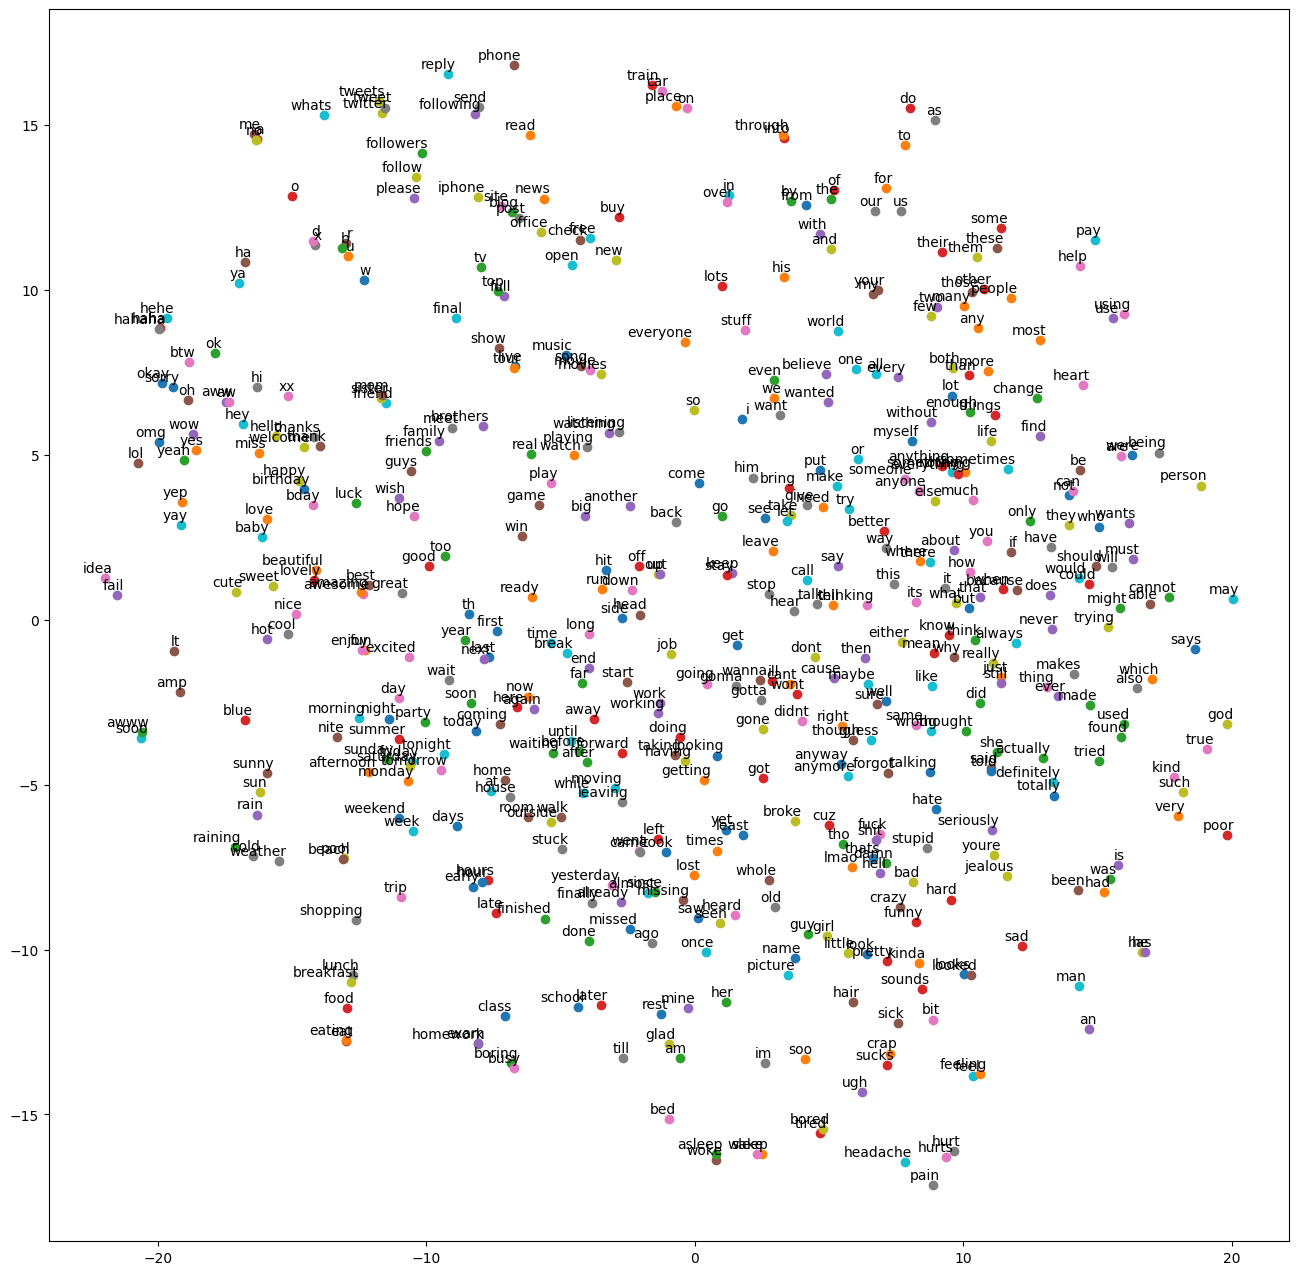

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def tsne(tokens=tokens):

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    tokens = np.array(tokens)
    new_values = tsne_model.fit_transform(tokens[:500])
    print(new_values.shape)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16,16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


tsne(tokens)

#### model building

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [ ]:
vec_size = 25

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length, weights = [word_vector_matrix], trainable = False))

# Add a Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=500, return_sequences=True)))

# Add a Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=200)))

# Add a dense output layer
model.add(Dense(units=100))

# Add a dense output layer
model.add(Dense(units=2, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs = 30, validation_data = (X_test, y_test))